In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install pandas
%pip install matplotlib
%pip install scikit-image
%pip install tqdm
%pip install torch
%pip install torchsummary

  Using cached pandas-2.2.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp310-cp310-macosx_10_9_x86_64.whl (12.6 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached contourpy-1.2.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 3.2 MB/s eta 0:00:0000:0100:01
Using cached contourpy-1.2.1-cp310-cp310-macosx_10_9_x86_64.whl

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from PIL import Image

from skimage.io import imread
from skimage.transform import resize

import torch
from torch.utils.data import DataLoader

import time
from tqdm import tqdm

# Загрузка данных

Делим на датасеты в соответствии с `split.csv`:

In [10]:
split_data = pd.read_csv('/Users/elizavetamanzula/Desktop/у(ч)еба/InstanceSegmentation/CVPPPSegmentation/CVPPPSegmData/split.csv')
train_split = split_data[split_data['split'] == 'train']
val_split = split_data[split_data['split'] == 'dev']
test_split = split_data[split_data['split'] == 'test']
train_split.head()

,split,img_path,sem_path,inst_path
0,train,data/A1/plant001_rgb.png,data/A1/plant001_fg.png,data/A1/plant001_label.png
1,train,data/A1/plant005_rgb.png,data/A1/plant005_fg.png,data/A1/plant005_label.png
2,train,data/A1/plant006_rgb.png,data/A1/plant006_fg.png,data/A1/plant006_label.png
3,train,data/A1/plant007_rgb.png,data/A1/plant007_fg.png,data/A1/plant007_label.png
4,train,data/A1/plant008_rgb.png,data/A1/plant008_fg.png,data/A1/plant008_label.png


Посмотрим на картинки:

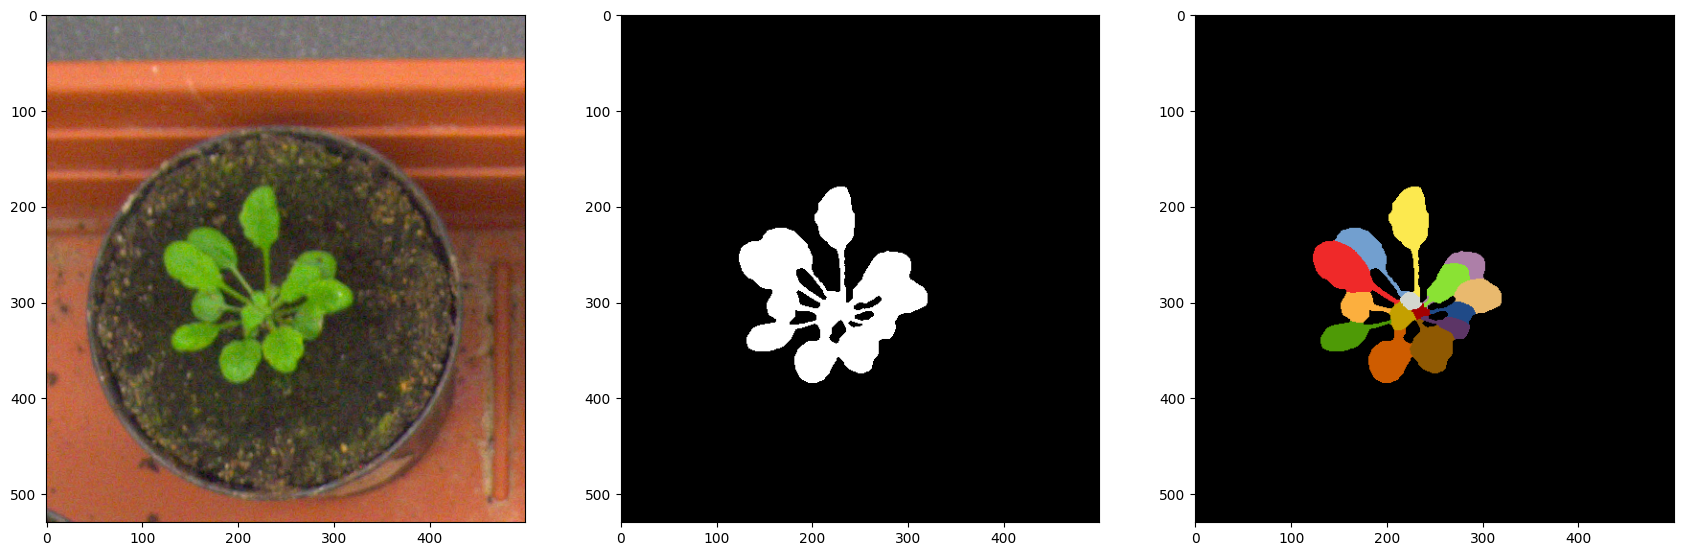

In [12]:
data_folder = '/Users/elizavetamanzula/Desktop/у(ч)еба/InstanceSegmentation/CVPPPSegmentation/CVPPPSegmData/'

example_img_path = data_folder + train_split.iloc[0]['img_path']
example_sem_path = data_folder + train_split.iloc[0]['sem_path']
example_inst_path = data_folder + train_split.iloc[0]['inst_path']

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

img = Image.open(example_img_path)
axs[0].imshow(img)

sem = Image.open(example_sem_path)
axs[1].imshow(sem)

inst = Image.open(example_inst_path)
axs[2].imshow(inst)

# Создание датасетов

Поменяем размер всех изображений на (480, 480).

In [13]:
size = (480, 480)

## Обработка изображений

Предсказания semantic-сегментации будем получать из предсказаний instance-сегментации, поэтому `sem`-картинки нам нужны не будут.

In [14]:
train_images = {"img": [], "sem": [], "inst": []}

for i in tqdm(range(len(train_split))):
    img_path = data_folder + train_split.iloc[i]['img_path']
    inst_path = data_folder + train_split.iloc[i]['inst_path']

    img_array = np.rollaxis(resize(imread(img_path)[:, :, :3], size, mode='constant'), 2, 0)
    inst_array = np.rollaxis(resize(imread(inst_path), size, mode='constant'), 2, 0)

    train_images["img"].append(np.asarray(img_array))
    train_images["inst"].append(np.asarray(inst_array))

100%|██████████| 712/712 [02:04<00:00,  5.70it/s]


In [15]:
train_images["img"][124].shape

(3, 480, 480)

In [16]:
val_images = {"img": [], "sem": [], "inst": []}

for i in tqdm(range(len(val_split))):
    img_path = data_folder + val_split.iloc[i]['img_path']
    inst_path = data_folder + val_split.iloc[i]['inst_path']

    img_array = np.rollaxis(resize(imread(img_path)[:, :, :3], size, mode='constant'), 2, 0)
    inst_array = np.rollaxis(resize(imread(inst_path), size, mode='constant'), 2, 0)

    val_images["img"].append(np.asarray(img_array))
    val_images["inst"].append(np.asarray(inst_array))

100%|██████████| 35/35 [00:06<00:00,  5.60it/s]


In [17]:
test_images = {"img": [], "sem": [], "inst": []}

for i in tqdm(range(len(test_split))):
    img_path = data_folder + test_split.iloc[i]['img_path']
    inst_path = data_folder + test_split.iloc[i]['inst_path']

    img_array = np.rollaxis(resize(imread(img_path)[:, :, :3], size, mode='constant'), 2, 0)
    inst_array = np.rollaxis(resize(imread(inst_path), size, mode='constant'), 2, 0)

    test_images["img"].append(np.asarray(img_array))
    test_images["inst"].append(np.asarray(inst_array))

100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


## Создание `DataLoader`-ов

In [18]:
batch_size = 10

train_loader = DataLoader(list(zip(train_images["img"], train_images["inst"])), 
                     batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(val_images["img"], val_images["inst"])),
                      batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(test_images["img"], test_images["inst"])),
                     batch_size=batch_size, shuffle=True)

# Инициализация модели

Будем использовать модель [DeepColoring](https://arxiv.org/pdf/1807.10007.pdf). Сама архитектура модели почти ничем не отличается от U-net (кроме размерности выхода, равной количеству цветов), а основные различия появляются именно в лоссе. Вместо бинарной кросс-энтропии, как в классической U-net, используется Halo-loss: <вставить формулу>.

In [44]:
from models import DeepColoring
from losses import HaloLoss
from inference import Inference
from torchsummary import summary

model = DeepColoring(colors=5)

Проверяем размерность выхода модели:

In [45]:
batch, label = next(iter(train_loader))
print(f"Размерность батча: {batch.shape} - [batch_size, channels, height, width]")
print(f"Размерность лейблов: {label.shape} - [batch_size, height, width]") # сейчас неверно, добавить предобработку
print(f"Размерность выхода модели: {model(batch).shape} - [batch_size, colors_number, height, width]")

Размерность батча: torch.Size([10, 3, 480, 480]) - [batch_size, channels, height, width]
Размерность лейблов: torch.Size([10, 3, 480, 480]) - [batch_size, height, width]
Размерность выхода модели: torch.Size([10, 5, 480, 480]) - [batch_size, colors_number, height, width]


In [32]:
def fit(optimizer, n_epochs):

    def _train_one_epoch():
        model.train()
        losses = []
        for batch, label in train_loader:
            predicted = model(batch)
            halo = HaloLoss(predicted, label)
            loss = halo.compute_loss()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss)
        return np.mean(losses)
    
    # def _eval_one_epoch():
    #     pass
    
    train_losses = []
    val_metrics = []

    for epoch in tqdm(range(n_epochs)):
        train_loss = _train_one_epoch()
        # val_metric = _eval_one_epoch()
        train_losses.append(train_loss)
        # val_metrics.append(val_metric)
        print(f"{epoch} ok")
    
    return train_losses, val_metrics

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses, metrics = fit(optimizer, n_epochs=1)

ok1


  0%|          | 0/1 [00:43<?, ?it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

RuntimeError: Boolean value of Tensor with more than one value is ambiguous